In [5]:
import keras
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
#import gym
import geopy.distance
import itertools
import math
import json
import numpy as np
import networkx as nx
from IPython.core.display import HTML
import random
%matplotlib inline

## DATA PROCESSING IS DONE:
## IMPORT OF THE PROCESSED DATAFRAMES

## df

In [6]:
df=pd.read_csv(r"processed_df.csv", sep=";")

## table index/state (from gps to int)

In [7]:
#removing the double elements in the states list
allpoints=np.array(pd.concat([df.original,df.connected]))
allpoints=pd.DataFrame(allpoints)
noeuds=list(dict.fromkeys(list(allpoints[0])))

In [8]:
#création of an index table: an integer associated to every nodes:
noeuds.sort()
d={'index':range(len(noeuds)),'state':noeuds}
table=pd.DataFrame(d)
table.head(4)


,index,state
0,0,"2.79087, 50.58488"
1,1,"2.79231, 50.58173"
2,2,"2.79403, 50.5833"
3,3,"2.79437, 50.54937"


In [9]:
graph_3=pd.read_csv(r"graph_3_processed.csv", sep=";")

In [10]:
graph_3=graph_3.drop_duplicates().reset_index(drop=True)
graph_3=graph_3.reset_index(drop=True)
graph_3.head(4)

,connected,original,sens unique,trafic,weight
0,1,2,0,0,13
1,0,2,0,0,21
2,3,6,0,1,30
3,13,6,0,0,38


The 13 different types of roads are:
- 0 'VOIE METROPOLITAINE'
- 1 'ROUTE DEPARTEMENTALE'
- 2 'VOIE PRIVEE OUVERTE'
- 3 'AUTRE VOIE PUBLIQUE'
- 4 'CHEMIN RURAL'
- 5 'Non codE'
- 6 'VOIE PRIVEE FERMEE' 
- 7 'ROUTE NATIONALE' 
- 8 'AUTRE VOIE PRIVEE'
- 9 'AUTOROUTE OU VOIE A CARACTERE AUTOROUTIER'
- 10 'DECLASSEMENT EN COURS'
- 11 'GESTION COMMUNAUTAIRE'
- 12 'VOIE PRIVEE ENTRETENUE PAR LA CUDL' 

## Creation of an initial graph g (not directed)

In [11]:
myList=graph_3[['original','connected','weight']].apply(tuple , axis=1)

In [12]:
myList=myList.drop_duplicates().reset_index(drop=True)
myList.head()

0     (2, 1, 13)
1     (2, 0, 21)
2     (6, 3, 30)
3    (6, 13, 38)
4    (8, 25, 55)
dtype: object

In [13]:
g=nx.Graph()
g.add_weighted_edges_from(myList)
len(g.edges)

45317

In [14]:
test=pd.DataFrame({'edge':list(zip(graph_3.original,graph_3.connected)),'sens unique':graph_3['sens unique'],'trafic':graph_3['trafic']})
test_reverse=pd.DataFrame({'edge':list(zip(graph_3.connected,graph_3.original)),'sens unique':graph_3['sens unique'],'trafic':graph_3['trafic']})
type_trafic_circu=test.append(test_reverse).reset_index(drop=True)
type_trafic_circu.head(4)



,edge,sens unique,trafic
0,"(2, 1)",0,0
1,"(2, 0)",0,0
2,"(6, 3)",0,1
3,"(6, 13)",0,0


## Test Dijkstra

In [246]:
print('path : ', nx.dijkstra_path(g,355,496), ' traveling time : ' ,nx.dijkstra_path_length(g,355,496), ' secondes.')

path :  [355, 497, 522, 525, 489, 498, 483, 493, 496]  traveling time :  202  secondes.


## Test A*

In [15]:
#definition de la distance euclidienne:
def distance_noeuds(noeud1,noeud2):
    return geopy.distance.distance(noeuds[int(noeud1)], noeuds[int(noeud2)]).km #*30 if we want to use it as an heuristic for A*


In [75]:
print('path : ', nx.astar_path(g,355,496,weight=3,heuristic=distance_noeuds), ' traveling time : ' ,nx.astar_path_length(g,355,496), ' secondes.')


path :  [355, 497, 522, 525, 489, 498, 483, 493, 496]  temps de parcours :  202  secondes.


## Directed Graph

In [16]:
Directed=g.to_directed()

In [17]:
for i in range(len(graph_3)):
    try :
        if graph_3['sens unique'][i]==1:
            Directed.remove_edge(graph_3.connected[i],graph_3.original[i])
    except:
        pass

In [18]:
print('graph_3:',len(graph_3),'/ Without duplicates: ', len(myList), '/ number of edges of the generated graph: ',len(list(g.edges)))


graph_3: 45812 / Without duplicates:  45723 / number of edges of the generated graph:  45499


In [19]:
print('graph 3 : ', len(graph_3), ' g : ', len(list(g.edges)), ' Directed : ', len(list(Directed.edges)))

graph 3 :  45812  g :  45499  Directed :  81378


## Test A*

In [20]:
START=355
END=1379

In [21]:
path=nx.astar_path(Directed,START,END,weight=3)
print('path : ', path, ' distance : ' ,nx.astar_path_length(Directed,START,END))  #we normally add heuristic=distance_nodes but the time saved in terms of convergence of the algo is (largely) compensated by the time of calculation of heuristics.


path :  [355, 497, 522, 525, 544, 623, 687, 796, 920, 928, 1083, 1441, 1456, 1386, 1332, 1029, 1013, 1020, 1119, 1330, 1211, 1152, 1188, 1541, 1350, 1275, 1315, 1154, 1001, 1144, 1328, 1295, 1015, 1059, 1196, 1402, 1400, 1383, 1290, 1337, 1344, 1352, 1347, 1357, 1375, 1385, 1407, 1379]  distance :  1913


As expected it works really well and we could improve the researche by incresing the Epsilone (weight) value. 

<br>
<br>
<br>

## Modelling of the traffic through time

Next step is to modelize the traffic. To do so, we'll introduce a notion of time:

- Every step, let's consider a there is a batch of drivers willing to go from a node to another one. We compute the shortest path and consider they took this itinerary.
- Then, we penalize the edges (roads) of the itinerary by increasing the weight of the edge. 
- Next step we compute the shortest path but with the updated network. 
- Moreover, the impact of the traffic on the roads vanishes in time so every step we decrease by a certain percentage the penalization of the edges wich have been penalized during the last steps. 

## First we'll have to define a penalization function giving the increase of average time to cross an hedge

## dict_para

In [22]:
#creation of a dictionnary giving the parameters regarding the average trafic of the road:
dict_para={'type_route':['VOIE METROPOLITAINE','ROUTE DEPARTEMENTALE', 'VOIE PRIVEE OUVERTE', 'AUTRE VOIE PUBLIQUE', 'CHEMIN RURAL','Non codE','VOIE PRIVEE FERMEE' ,'ROUTE NATIONALE' ,'AUTRE VOIE PRIVEE','AUTOROUTE OU VOIE A CARACTERE AUTOROUTIER','DECLASSEMENT EN COURS','GESTION COMMUNAUTAIRE','VOIE PRIVEE ENTRETENUE PAR LA CUDL'], 'Kv':[150, 300, 150, 150, 100, 150, 10, 500, 100, 1000, 150, 150, 150],'alpha_v':[2, 4, 2, 2, 2, 2, 2, 4, 2, 6, 2, 2, 2],'gam_v':[0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18]} 
dict_para=pd.DataFrame(dict_para) 
dict_para

,type_route,Kv,alpha_v,gam_v
0,VOIE METROPOLITAINE,150,2,0.18
1,ROUTE DEPARTEMENTALE,300,4,0.18
2,VOIE PRIVEE OUVERTE,150,2,0.18
3,AUTRE VOIE PUBLIQUE,150,2,0.18
4,CHEMIN RURAL,100,2,0.18
5,Non codE,150,2,0.18
6,VOIE PRIVEE FERMEE,10,2,0.18
7,ROUTE NATIONALE,500,4,0.18
8,AUTRE VOIE PRIVEE,100,2,0.18
9,AUTOROUTE OU VOIE A CARACTERE AUTOROUTIER,1000,6,0.18


## Definition of the coef_penalisation and the parametres functions

In [23]:
def coef_penalisation (debit,type_route):
    Kv,alphav,gam_v=parametres(type_route)
    alphav=int(alphav)
    return (1+gam_v*(debit/Kv)**alphav)
def parametres (type_route):
    return list(dict_para[['Kv','alpha_v','gam_v']].iloc[type_route])

In [24]:
#test
coef_penalisation(200,3)

1.3199999999999998

Let's plot the time travel of 1km on a 90km road (assuming a type 3) depending on the density of the trafic:

In [25]:
import matplotlib.pyplot as plt
l=[]
for i in range(0, 1000,20):
   l.append([i,40*coef_penalisation(i,0)]) 

<function matplotlib.pyplot.show>

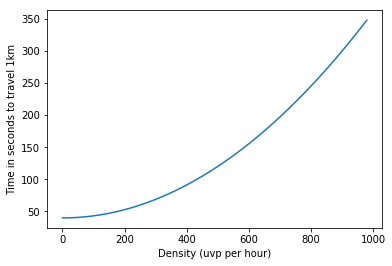

In [26]:
plt.plot(pd.DataFrame(l)[0],pd.DataFrame(l)[1])
plt.ylabel('Time in seconds to travel 1km')
plt.xlabel('Density (uvp per hour)')
plt.show

In [27]:
print('For no users on the road the penalization coefficient is : ', coef_penalisation(0,3),' ; and for the saturation density, the penalization coefficient is : ', coef_penalisation(150,0))

For no users on the road the penalization coefficient is :  1.0  ; and for the saturation density, the penalization coefficient is :  1.18


We now have a penalization function. So for every iteration we can compute a the updated weight for every hedges. 

In [28]:
#comment obtenir le type de route d'un edge:
type_edge=pd.DataFrame({'edge':list(zip(graph_3.original,graph_3.connected)),'type_road':graph_3.trafic})
type_edge_reversed=pd.DataFrame({'edge':list(zip(graph_3.connected,graph_3.original)),'type_road':graph_3.trafic})
type_edge=type_edge.append(type_edge_reversed)
type_edge.reset_index(drop=True)
type_edge.head(4)

,edge,type_road
0,"(2, 1)",0
1,"(2, 0)",0
2,"(6, 3)",1
3,"(6, 13)",0


# FINAL

# flow_edges

In [29]:
#update of the weights of the graph:
""" nota bene: we have to keep a trace of the flow (debit) on every hedges along the iterations.
We can not just remultiply the last weight by the penalization coefficient but
we need to recompute the penalization coefficient from the updated flow (value at t-1 + new comers) 
and multiply it to the initial weight."""

#creation of an array with the number of users on every hedges. Initialize at 0:
flow_edges=pd.DataFrame({'edge':list(Directed.edges),'flow':[0]*len(Directed.edges)})

  <br>
 <br>


## Random generating function of (start, end) and the path and time list associated

Function allowing to randomly generate a given number of agents using different paths and returning a list of path vectors, a list of time vectors and the position arrays initialized.

In [30]:
nb_nodes=len(list(Directed.nodes))

In [31]:
def path_generation(graph,nb_path=1,t0=0,taille_paquets=100):
    P=[]    #list of the edges of the generated paths
    T=[]    #list of the list of time to travel until the i'th edge
    B=[]    #list of the lists of boolean giving the position of a group of agent on their path
    for i in range(nb_path):
        start=random.choice(range(nb_nodes))      
        try:
            end=random.choice(range(nb_nodes))
            path_i=nx.astar_path(graph,start,end,weight=3)
        except:                                 #the list of reachable nodes (nx.descendants) is only used when the randomly selected end node is not reachable to save computation time because the probability remains low
            end=random.choice(list(nx.descendants(graph,start)))
            path_i = nx.astar_path(graph,start,end,weight=3)
        
        path_i_tuple=[(path_i[k], path_i[k+1]) for k in range(len(path_i)-1)]
        P.append(path_i_tuple)
        
        time_i=list(map(lambda x:Directed.edges[x]['weight'],path_i_tuple))
        T_i=list(np.array([time_i[0]])+t0)
        for i in range(len(time_i)-1):
            T_i.append(T_i[i]+time_i[i+1])
        T.append(list(T_i))
        #add of a booleen list with the position of the package on its path
        b_i=[False]*len(path_i_tuple)
        b_i[0]=True #initialization: the package is on the first edge
        B.append(b_i)
        #initialization of the flow_edges array
        flow_edges.loc[flow_edges.edge==(path_i[0], path_i[1]),'flow']+=taille_paquets
    return(P,T,B)


## Flowing function

In [33]:
def ecoulement(P,T,B,t,taille_paquets=100):  
    '''This function is used to update the boolean array of the group of agents position on its path.
    As well as the vector flow. 
    P being the list of paths, T the list of transit times and t the current time it is.
    On the other hand, in order to minimize the calculation time in the update of the graph weights, it returns the concerned edges (road section wich have a new number of user on)
    (TBD: upgrade the function: it might not work properly when it is launched several times on the same t)'''

    arretes_modifiees=[]
    for i in range(len(P)):
        if t<T[i][0]:
            arretes_modifiees.append(P[i][0])  
            """if t is less than the starting time the flow function returns the first edge as the only edge to be updated
            No need to update the flow vector in this case.
            This update (concerning the first edge of a path) is done when it is created by the path generation function"""
           
        for j in range(len(T[i])-1):
            if T[i][j]<=t<T[i][j+1]:  #if the current time correspond to a travelling time for the path. The pack is then on a certain edge of its path.
                arrete_arrive=P[i][j+1]
                flow_edges.loc[flow_edges.edge==P[i][j+1],'flow'] += taille_paquets #add of taille_paquet (pack size ; number of drivers associated to a path) to the edge (raod section) in which the pack is supposed to be at the considered time)
                B[i][j+1]=True    #updating of the boolean array for the position of the agent on its path.
                arrete_prec=np.where(np.array(B[i])==True)[0][0]  #index of the edge on which the pack was the last time the flow_edges array was updated
                B[i][arrete_prec]=False
                flow_edges.loc[flow_edges.edge==P[i][arrete_prec],'flow']-= taille_paquets  
                arrete_depart=P[i][arrete_prec]
                arretes_modifiees.append([arrete_depart,arrete_arrive])
        if t>=T[i][-1]:      #if the agent is already arrived at destination
            try:
                arrete_prec=np.where(np.array(B[i])==True)[0][0]  #index of the edge on which the pack was the last time the flow_edges array was updated
                arrete_depart=P[i][arrete_prec]
                B[i][arrete_prec]=False
                flow_edges.loc[flow_edges.edge==P[i][arrete_prec],'flow']-= taille_paquets
                arretes_modifiees.append([arrete_depart])
            except:
                pass
    return(arretes_modifiees)   #the list of the edges whose weights are to be updated (to input in the update_weight function)
            
 

In [39]:
#TEST
#reinitialization of the flow array at 0:
flow_edges=pd.DataFrame({'edge':list(Directed.edges),'flow':[0]*len(Directed.edges)})
#generation of 3 packs of size 200 at time t = 1000 secondes
x=path_generation(Directed,3,1000,200)
P=x[0]
T=x[1]
B=x[2]

In [40]:
T

[[1103,
  1156,
  1230,
  1293,
  1336,
  1415,
  1427,
  1579,
  1594,
  1653,
  1674,
  2081,
  2087,
  2096,
  2146,
  2485,
  2532,
  2570,
  2597,
  2676,
  2883,
  2898,
  2998,
  3084,
  3089,
  3108,
  3111,
  3123,
  3195,
  3230,
  3255,
  3274,
  3749,
  3764,
  3777,
  3778,
  4185,
  4828,
  5471,
  6107,
  6491,
  6985,
  7342,
  7485,
  7489,
  7509,
  7786,
  7948,
  7953,
  7986,
  7996,
  8031,
  8041,
  8052,
  8088,
  8095,
  8143,
  8266,
  8338,
  8389,
  8445,
  8639,
  8645,
  8661,
  8695],
 [1072,
  1084,
  1107,
  1161,
  1169,
  1177,
  1251,
  1257,
  1326,
  1368,
  1391,
  1627,
  1818,
  1835,
  1841,
  1874,
  1880,
  1885,
  1888,
  1910,
  2056,
  2087,
  2091,
  2110,
  2113,
  2122,
  2127,
  2289,
  2566,
  2787,
  3399,
  3747,
  3749,
  3751,
  3767,
  3775,
  3783,
  3790,
  3795,
  3805,
  3816,
  3820,
  3906,
  3930,
  3936,
  3939,
  3998,
  4000,
  4005,
  4009,
  4011,
  4026,
  4030,
  4058,
  4072,
  4079,
  4081,
  4120,
  4153,
  4171,

In [41]:
flow_edges[flow_edges.flow==200]

,edge,flow
1135,"(559, 491)",200
52109,"(22875, 23039)",200
73703,"(32076, 32095)",200


In [42]:
A=ecoulement(P,T,B,1600,200)

In [43]:
flow_edges[flow_edges.flow==200]

,edge,flow
2361,"(1029, 1332)",200
53510,"(23417, 23052)",200
69994,"(30707, 30461)",200


In [44]:
A #returning the edges to be modified by the following function

[[(22875, 23039), (23417, 23052)],
 [(559, 491), (1029, 1332)],
 [(32076, 32095), (30707, 30461)]]

The unit tests are conclusive.

## Weight update function V2

In [45]:
initial_graph=Directed #to keep a record of the original wheighs 

In [46]:

def update_weights (flow_edges,graph,A):
    """A being the list of edges to be updated. A is generated by the flow function;
    This means that not every edges of the graph has to be updated. 
    We thus reduce the calculation time. Indeed, calculate the flow/time ('coef_penalisation') function for each section 
    of the graph and modify the value of each stop in the graph (82000 in our dataset) would be extremely time-consuming to calculate"""    
    for i in range(len(A)):
        for j in range(len(A[i])):
            init_weight=initial_graph.edges[A[i][j]]['weight']
            type_arrete=int(type_edge[type_edge.edge==A[0][0]].type_road)
            coef_penal=coef_penalisation(debit = float(flow_edges[flow_edges.edge==A[i][j]].flow) , type_route = int(type_edge[type_edge.edge==A[0][0]].type_road))
            #Directed.edges[A[i][j]]['weight']=initial_graph.edges[A[i][j]]['weight']*coef_penalisation(debit=flow_edges['flow'][np.where(flow_edges['edge']==tuple(edge))[0][0]],type_route=test.trafic.iloc[np.where(test.edge==tuple(edge))[0][0]])
            print('modified edge :', A[i][j],'\ntype of road section : ',type_arrete, ' \nweight without users : ', init_weight, '\npenalisation coefficient : ', coef_penal,'\n')
            Directed.edges[A[i][j]]['weight']=init_weight*coef_penal
            
            

Unitary test:

In [47]:
update_weights(flow_edges,Directed,A)

modified edge : (22875, 23039) 
type of road section :  0  
weight without users :  103 
penalisation coefficient :  1.0 

modified edge : (23417, 23052) 
type of road section :  0  
weight without users :  59 
penalisation coefficient :  1.3199999999999998 

modified edge : (559, 491) 
type of road section :  0  
weight without users :  72 
penalisation coefficient :  1.0 

modified edge : (1029, 1332) 
type of road section :  0  
weight without users :  236 
penalisation coefficient :  1.3199999999999998 

modified edge : (32076, 32095) 
type of road section :  0  
weight without users :  1 
penalisation coefficient :  1.0 

modified edge : (30707, 30461) 
type of road section :  0  
weight without users :  190 
penalisation coefficient :  1.3199999999999998 



In [48]:
Directed.edges[A[0][1]]['weight']

77.88

The update_weight function works as expected: it changes the weights of the edges concerned by a flow modification depending on the type of road and the number of users on the edge/road section.

<br> <br>

## Improvement in the options of path generation

We would like to add the possibility to chose a starting and arriving location. The following function then make possible to specify a starting point, arriving point and a radius in order to get a list of potential starting and arriving points and the path_generation function has been modified (__path_generation_2__) to allow the possibility to input the output of __start_end_area__ function and generate those specific paths. 

In [242]:
def start_end_area(start_node,end_node,radius): 
    Dist_start=[distance_noeuds(start_node,n) for n in list(Directed.nodes)] #distance array between the different nodes and the starting point chosen
    starting_points=list(np.where(np.array(Dist_start)<=radius)[0]) #list of the possible starting points (the ones which are closer to the reference point than the radius inputed)
    Dist_end=[distance_noeuds(end_node,n) for n in list(Directed.nodes)]
    end_points=list(np.where(np.array(Dist_end)<=radius)[0])
    return(starting_points,end_points)



In [243]:
#adding the possibility to choose an starting area and an arriving area:
def path_generation_2(graph,nb_path=1,t0=0,taille_paquets=100,area=False):
    P=[]    #list of the edges of the generated paths
    T=[]    #list of the list of time to travel until the i'th edge
    B=[]    #list of the lists of boolean giving the position of a group of agent on their path
    if area:
        for i in range(nb_path):
            start=random.choice(area[0])     
            try:
                end=random.choice(area[1])
                path_i=nx.astar_path(graph,start,end,weight=3)
            except:                                 #the list of reachable nodes (nx.descendants) is only used when the randomly selected end node is not reachable to save computation time because the probability remains low
                end=random.choice(join(list(nx.descendants(graph,start)),area[1]))
                path_i = nx.astar_path(graph,start,end,weight=3)

            path_i_tuple=[(path_i[k], path_i[k+1]) for k in range(len(path_i)-1)]
            P.append(path_i_tuple)

            time_i=list(map(lambda x:Directed.edges[x]['weight'],path_i_tuple))
            T_i=list(np.array([time_i[0]])+t0)
            for i in range(len(time_i)-1):
                T_i.append(T_i[i]+time_i[i+1])
            T.append(list(T_i))
            #add of a booleen list with the position of the package on its path
            b_i=[False]*len(path_i_tuple)
            b_i[0]=True #initialization: the package is on the first edge
            B.append(b_i)
            #initialization of the flow_edges array
            flow_edges.loc[flow_edges.edge==(path_i[0], path_i[1]),'flow']+=taille_paquets
    else:
        path_generation(graph,nb_path,t0,taille_paquets)
    return(P,T,B)
        #T.append()

In [244]:
area=start_end_area(137,2056,1)

In [245]:
path_generation_2(Directed,nb_path=3,area=area)

([[(33, 51),
   (51, 55),
   (55, 59),
   (59, 112),
   (112, 121),
   (121, 124),
   (124, 130),
   (130, 141),
   (141, 149),
   (149, 163),
   (163, 170),
   (170, 172),
   (172, 175),
   (175, 178),
   (178, 194),
   (194, 206),
   (206, 223),
   (223, 242),
   (242, 272),
   (272, 282),
   (282, 311),
   (311, 316),
   (316, 327),
   (327, 339),
   (339, 346),
   (346, 361),
   (361, 370),
   (370, 373),
   (373, 367),
   (367, 379),
   (379, 553),
   (553, 561),
   (561, 564),
   (564, 808),
   (808, 971),
   (971, 1096),
   (1096, 1092),
   (1092, 1083),
   (1083, 1441),
   (1441, 1456),
   (1456, 1386),
   (1386, 1332),
   (1332, 1029),
   (1029, 1013),
   (1013, 1020),
   (1020, 1119),
   (1119, 1330),
   (1330, 1211),
   (1211, 1152),
   (1152, 1188),
   (1188, 1541),
   (1541, 1656),
   (1656, 1758),
   (1758, 2043),
   (2043, 2000),
   (2000, 1926),
   (1926, 1838)],
  [(31, 30),
   (30, 27),
   (27, 21),
   (21, 14),
   (14, 6),
   (6, 13),
   (13, 160),
   (160, 193),
   

It works as expected. In order to avoid long calculus time while we generate several paths through time, __start_end_area__ function better be defined outside __path_generation_2__.

<br> <br>

# DYNAMIC TEST OF THE ALGO 

We are going to create a meta function that takes in parameters: 
- the interval of time we want __Time__ : which is the moment we stop the modelization if we begin at $t_{0}=0$ 
- the time step: let's say we want to update the graph and generate new users every 10 secondes. Default value 10. 
- the number of path generated at every step
- the number of users/cars associated to every path

# BROUILLON

In [215]:
area=(137,2056,1)
Dist_start=[distance_noeuds(area[0],n) for n in list(Directed.nodes)] #distance array between the different nodes and the starting point chosen
starting_points=list(np.where(np.array(Dist_start)<=area[2])[0]) #list of the possible starting points (the ones which are closer to the reference point than the radius inputed)
Dist_end=[distance_noeuds(area[1],n) for n in list(Directed.nodes)]
end_points=list(np.where(np.array(Dist_end)<=area[2])[0])

In [231]:
if area[0] & (area[1] & area[2]):
    print('yo')

In [740]:
for i in range(len(A)):
    for j in range(len(A[i])):
        float(graph_3[np.logical_and(graph_3.original==A[i][j][0], graph_3.connected == A[i][j][1])].weight)

TypeError: cannot convert the series to <class 'float'>

In [804]:
for i in range(len(A)):
    for j in range(len(A[i])):
        print(initial_graph.edges[A[i][j]]['weight'])

9
243
19
125
17
102


In [785]:
ecoulement(P,T,B,1500)

[[(19872, 19352), (19352, 18900)],
 [(3758, 3806), (3806, 3821)],
 [(32211, 32002), (32249, 32732)]]

In [750]:
graph_3[np.logical_and(graph_3.original==A[2][0][0], graph_3.connected == A[2][0][1])].weight

Series([], Name: weight, dtype: int64)

In [751]:
Directed.edges[6116, 6396]

{'weight': 20}

In [754]:
graph_3[graph_3.original==A[2][0][0]]

,connected,original,sens unique,trafic,weight
7613,6111,6116,0,0,2
7614,5564,6116,0,1,46


## UNITARY TEST OF THE DATA PROCESSING: 

In [1104]:
df_check=pd.read_csv(r"voies_temps.csv", sep=";")
### add of the start and arriving gps values
def getstart (geoshape):
    debut=geoshape.find("[")
    fin=geoshape.find("]")
    start=geoshape[debut+2:fin].split(", ")
    lat=round(float(start[0]),5)
    lon=round(float(start[1]),5)
    return str(lat) + ', ' + str(lon)
df_check["START"]=df_check['Geo Shape'].apply(func=getstart)

def getend (geoshape):
    debut=geoshape.rfind("[")
    fin=geoshape.rfind("]")
    start=geoshape[debut+1:fin-1].split(", ")
    lat=lat=round(float(start[0]),5)
    lon=round(float(start[1]),5)
    return str(lat) + ', ' + str(lon)
df_check["END"]=df_check['Geo Shape'].apply(func=getend)


df_check.reset_index(inplace = True)

df_check=pd.DataFrame({'start': df_check.START, 'end': df_check.END, 'type' : df_check.DOMANIALIT})
df_check.head(20) #df_check is the reference table in order to check if the type is the right one in graph_3 and df (processed one)

,end,start,type
0,"3.14459, 50.66536","3.14565, 50.66453",VOIE METROPOLITAINE
1,"3.16217, 50.61329","3.1626, 50.613",VOIE METROPOLITAINE
2,"3.15413, 50.63812","3.15521, 50.6361",ROUTE DEPARTEMENTALE
3,"3.15961, 50.61919","3.15942, 50.61909",VOIE METROPOLITAINE
4,"3.15995, 50.61939","3.15961, 50.61919",VOIE METROPOLITAINE
5,"3.16186, 50.62047","3.16043, 50.61969",VOIE METROPOLITAINE
6,"3.16306, 50.62168","3.16298, 50.62154",VOIE METROPOLITAINE
7,"3.16173, 50.61878","3.16154, 50.6189",VOIE METROPOLITAINE
8,"3.12787, 50.6371","3.12813, 50.6365",VOIE METROPOLITAINE
9,"3.12721, 50.63875","3.12725, 50.63807",VOIE METROPOLITAINE


Check of df:

In [1105]:
t=[]
for i in range(len(df[df.trafic==8])):
   # print(table.iloc[graph_3[graph_3.trafic==11].iloc[i].original].state,table.iloc[graph_3[graph_3.trafic==11].iloc[i].connected].state)
   t.append(df_check[(df_check.start==df[graph_3[graph_3.trafic==8].iloc[i].original].state) & (df_check.end == table.iloc[graph_3[graph_3.trafic==8].iloc[i].connected].state) ].type.iloc[0])


SyntaxError: invalid syntax (<ipython-input-1105-a09a5ac421d1>, line 4)

In [1120]:
table

,index,state
0,0,"2.79087, 50.58488"
1,1,"2.79231, 50.58173"
2,2,"2.79403, 50.5833"
3,3,"2.79437, 50.54937"
4,4,"2.79618, 50.55009"
5,5,"2.79667, 50.59118"
6,6,"2.79681, 50.54599"
7,7,"2.79868, 50.52935"
8,8,"2.7991, 50.52895"
9,9,"2.7992, 50.52979"


In [1085]:
df_check=df_check.sort_values(by='start')
df_check=df_check.reset_index()
del df_check['index']

In [1086]:
df_check['weight']=df.weight
df_check['SENS UNIQUE']=df['SENS UNIQUE']
df_check.head(10)

,end,start,type,weight,SENS UNIQUE
0,"2.79231, 50.58173","2.79403, 50.5833",NaN,13,0
1,"2.79087, 50.58488","2.79403, 50.5833",NaN,21,0
2,"2.79437, 50.54937","2.79681, 50.54599",ROUTE DEPARTEMENTALE,30,0
3,"2.80019, 50.5475","2.79681, 50.54599",VOIE METROPOLITAINE,38,0
4,"2.80116, 50.52781","2.7991, 50.52895",VOIE METROPOLITAINE,55,0
5,"2.7992, 50.52979","2.79933, 50.52944",VOIE PRIVEE OUVERTE,7,0
6,"2.79868, 50.52935","2.79933, 50.52944",VOIE METROPOLITAINE,4,0
7,"2.79933, 50.52944","2.80002, 50.52956",VOIE METROPOLITAINE,6,0
8,"2.8005, 50.52906","2.80002, 50.52956",VOIE PRIVEE OUVERTE,14,0
9,"2.79618, 50.55009","2.80019, 50.5475",VOIE METROPOLITAINE,72,0


In [1065]:
df

,original,connected,weight,SENS UNIQUE,trafic
0,"2.79403, 50.5833","2.79231, 50.58173",13,0,0
1,"2.79403, 50.5833","2.79087, 50.58488",21,0,0
2,"2.79681, 50.54599","2.79437, 50.54937",30,0,1
3,"2.79681, 50.54599","2.80019, 50.5475",38,0,0
4,"2.7991, 50.52895","2.80116, 50.52781",55,0,0
5,"2.79933, 50.52944","2.7992, 50.52979",7,0,2
6,"2.79933, 50.52944","2.79868, 50.52935",4,0,0
7,"2.80002, 50.52956","2.79933, 50.52944",6,0,0
8,"2.80002, 50.52956","2.8005, 50.52906",14,0,2
9,"2.80019, 50.5475","2.79618, 50.55009",72,0,0


In [1087]:
df_check.type.fillna('VOIE METROPOLITAINE',inplace=True)

In [1088]:
liste_types=df_check.type.unique()
liste_types

array(['VOIE METROPOLITAINE', 'ROUTE DEPARTEMENTALE',
       'VOIE PRIVEE OUVERTE', 'AUTRE VOIE PUBLIQUE', 'CHEMIN RURAL',
       'Non codE', 'VOIE PRIVEE FERMEE', 'ROUTE NATIONALE',
       'AUTRE VOIE PRIVEE', 'AUTOROUTE OU VOIE A CARACTERE AUTOROUTIER',
       'DECLASSEMENT EN COURS', 'GESTION COMMUNAUTAIRE',
       'VOIE PRIVEE ENTRETENUE PAR LA CUDL'], dtype=object)

In [1089]:
#on remplace les types de routes dans df par un indice associé:
def replace_by_index(string):
    return (int(np.where(liste_types==string)[0]))
replace_by_index(df_check.type[0])

0

In [1091]:
df_check.type=df_check.type.apply(replace_by_index)

In [1030]:
t=[]
type_edge=5
for i in range(len(graph_3[graph_3.trafic==type_edge])):
   # print(table.iloc[graph_3[graph_3.trafic==11].iloc[i].original].state,table.iloc[graph_3[graph_3.trafic==11].iloc[i].connected].state)
   t.append(df_check[(df_check.start==df.original[df.trafic==type_edge].iloc[i] ) & (df_check.end == df.connected[df.trafic==type_edge].iloc[i]) ].type.iloc[0])



In [1098]:
sum(abs(df_check.type-df.trafic))

0

In [1003]:
df_check[(df_check.start==df.original[df.trafic==10].iloc[1] ) & (df_check.end == df.connected[df.trafic==10].iloc[1]) ]

,end,start,type
9537,"3.11058, 50.78151","3.11095, 50.7814",DECLASSEMENT EN COURS


In [1001]:
export_csv = df_check.to_csv(r'df_check.csv', sep = ';' ,index = None, header=True)


In [994]:
df.original[df.trafic==2].iloc[4] 

'2.80116, 50.52878'

In [806]:
coef_penalisation(debit=flow_edges['flow'][flow_edges.edge==A[0][0]]

52718    0
Name: flow, dtype: int64

In [980]:
df

,original,connected,weight,SENS UNIQUE,trafic
0,"2.79403, 50.5833","2.79231, 50.58173",13,0,0
1,"2.79403, 50.5833","2.79087, 50.58488",21,0,0
2,"2.79681, 50.54599","2.79437, 50.54937",30,0,1
3,"2.79681, 50.54599","2.80019, 50.5475",38,0,0
4,"2.7991, 50.52895","2.80116, 50.52781",55,0,0
5,"2.79933, 50.52944","2.7992, 50.52979",7,0,2
6,"2.79933, 50.52944","2.79868, 50.52935",4,0,0
7,"2.80002, 50.52956","2.79933, 50.52944",6,0,0
8,"2.80002, 50.52956","2.8005, 50.52906",14,0,2
9,"2.80019, 50.5475","2.79618, 50.55009",72,0,0


In [862]:
df.trafic.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [808]:
A[0][0]

(20727, 20728)

In [741]:
float(graph_3[np.logical_and(graph_3.original==A[0][0][0], graph_3.connected == A[0][0][1])].weight)

218.0

In [746]:
float(graph_3[np.logical_and(graph_3.original==A[i][j][0], graph_3.connected == A[i][j][1])].weight)

206.0

In [743]:
A[0][1]

(21840, 22764)

In [294]:
l=[False]*10
l[2]=True
l

[False, False, True, False, False, False, False, False, False, False]

In [43]:
flow_edges[flow_edges.edge==(p[2][0],p[2][1])]

,edge,flow


In [198]:
P[0]

[(33313, 33316),
 (33316, 33327),
 (33327, 33548),
 (33548, 33808),
 (33808, 33899),
 (33899, 34042),
 (34042, 34127),
 (34127, 34225),
 (34225, 34251),
 (34251, 34319),
 (34319, 34308),
 (34308, 34023),
 (34023, 33986),
 (33986, 33940),
 (33940, 33951),
 (33951, 33992),
 (33992, 34005),
 (34005, 33926),
 (33926, 33885),
 (33885, 33884),
 (33884, 33747),
 (33747, 33778),
 (33778, 33733),
 (33733, 33494),
 (33494, 31538),
 (31538, 31523),
 (31523, 31466),
 (31466, 31425),
 (31425, 29698),
 (29698, 28899),
 (28899, 27613),
 (27613, 27334),
 (27334, 26983),
 (26983, 26579),
 (26579, 25896),
 (25896, 25440),
 (25440, 25099),
 (25099, 25068),
 (25068, 24766),
 (24766, 24603),
 (24603, 24069),
 (24069, 23802),
 (23802, 23495),
 (23495, 23417),
 (23417, 23052),
 (23052, 22657),
 (22657, 21443),
 (21443, 22650),
 (22650, 23351),
 (23351, 24829),
 (24829, 25293),
 (25293, 25565),
 (25565, 24805),
 (24805, 24083),
 (24083, 23875),
 (23875, 23816),
 (23816, 23823),
 (23823, 23822),
 (23822, 23890

In [33]:
v=[[3,12,17,26,47,52,59,71,110,200],[30,72,79,103,194,310],[29,69,148,290,410]]

In [273]:
len(Directed.edges)

81378

In [281]:
taille_paquets=10
def ecoulement(P,T,t):  
    '''P étant la liste des chemins, T la liste des temps de passage et t le temps auquel on en est'''
    for i in range(len(P)):
        for j in range(len(T[i])-1):
            if t==T[i][j]:    #on pourra ici utiliser div euclidienne ou < si on veut pas mettre a jour à chaque secondes
                flow_edges.loc[flow_edges.edge==P[i][j],'flow'] -= taille_paquets
                flow_edges.loc[flow_edges.edge==P[i][j+1],'flow'] += taille_paquets
                print(i,j)
        if t==T[i][-1]:      #si on est arrivé à destination
                flow_edges.loc[flow_edges.edge==P[i][-1],'flow'] -= taille_paquets
                print(i,j)                          
                                             

In [312]:
flow_edges.loc[P[0][np.where(np.array([False,False,True,False,True,False,False])==True)[0][0]],'flow']

29684    0
29616    0
Name: flow, dtype: int64

In [320]:
flow_edges.loc[flow_edges.edge==P[0][np.where(np.array([False,False,True,False,True,False,False])==True)[0][0]],'flow']-=10



In [323]:
flow_edges.loc[flow_edges.edge==P[0][np.where(np.array([False,False,True,False,True,False,False])==True)[0][0]],'flow']

67929   -10
Name: flow, dtype: int64

In [282]:
taille_paquets=10

def ecoulement(P,T,t):  
    '''P étant la liste des chemins, T la liste des temps de passage et t le temps auquel on en est'''
    for i in range(len(P)):
        for j in range(len(T[i])-1):
            if T[i][j]<=t<T[i][j+1]:  
                flow_edges.loc[flow_edges.edge==P[i][j+1],'flow'] -= taille_paquets
                flow_edges.loc[flow_edges.edge==P[i][j-1],'flow'] += taille_paquets
                print(i,j)
        if t==T[i][-1]:      #si on est arrivé à destination
                flow_edges.loc[flow_edges.edge==P[i][-1],'flow'] -= taille_paquets
                print(i,j)  

0
1
2


In [118]:
Directed.edges[arretes_a_updater[3]]['weight']

0.07271089727950131

In [112]:
arretes_a_updater=[]
for i in range (len(graph_3)):
    if flow_edges.flow[i]!=0:
        arretes_a_updater.append(flow_edges.edge[i])

In [116]:
Directed.arretes_a_updater[1]

(331.0, 342.0)

In [110]:
liste_test

[(13.0, 4.0)]

In [92]:
(testflow.flow*=0.5).round()

SyntaxError: invalid syntax (<ipython-input-92-6829360e297a>, line 1)

In [79]:
flow_edges.flow[np.where(flow_edges.edge==(355,356))[0][0]]

200

In [72]:
Directed[355][356]

{'weight': 0.018359517010301002}

In [89]:
Directed[355]

AtlasView({356.0: {'weight': 0.01390872500780379}})

In [101]:
a = [13,32,42,81,392,329]

In [ ]:
[(13,32),(32,42),(42,81),(81,392),(392,329)]

In [102]:
[(a[k], a[k+1]) for k in range(len(a)-1)]

[(13, 32), (32, 42), (42, 81), (81, 392), (392, 329)]

In [343]:
Directed.edges[(355,356)]['weight']

0.01390872500780379

In [347]:
for i in range(len(path)-1):
    #updating of the weights of the differents edges:
    edge=path[i:i+2] 
    Directed.edges[edge]['weight']*=coef_penalisation(debit=flow_edges['flow'][np.where(flow_edges['edge']==tuple(edge))[0][0]],type_route=test.trafic.iloc[np.where(test.edge==tuple(edge))[0][0]])


In [348]:
edge=[355,356]
coef_penalisation(debit=flow_edges['flow'][np.where(flow_edges['edge']==tuple(edge))[0][0]],type_route=test.trafic.iloc[np.where(test.edge==tuple(edge))[0][0]])
Directed.edges[edge]['weight']


0.014403257452525704

In [416]:
#comment obtenir le flow associé à un edge:
flow_edges=pd.DataFrame({'edge':list(Directed.edges),'flow':[0]*len(Directed.edges)})
flow_edges
flow_edges['flow'][np.where(flow_edges['edge']==(2.0,6.0))[0][0]]

0

In [118]:
i=2
edge=path[i:i+2]
test.trafic[np.where(test.edge==tuple(edge))[0][0]]

NameError: name 'path' is not defined

In [447]:
edge=path[0:2]
type_edge.type_road[np.where(type_edge.edge==edge)]

ValueError: Arrays were different lengths: 3957 vs 2

In [453]:
type_edge.type_road[np.where(type_edge.edge==tuple(edge))[0][0]]

3

In [460]:
flow_edges['flow'][np.where(flow_edges['edge']==tuple(edge))[0][0]]

0

In [466]:
for i in range(len(path)-1):
    edge=path[i:i+2]
    print(coef_penalisation(debit=flow_edges['flow'][np.where(flow_edges['edge']==tuple(edge))[0][0]],type_route=type_edge.type_road[np.where(type_edge.edge==tuple(edge))[0][0]]))

1.0
1.0


IndexError: index 0 is out of bounds for axis 0 with size 0

In [470]:
edge=path[2:4]
print(edge)
print(coef_penalisation(debit=flow_edges['flow'][np.where(flow_edges['edge']==tuple(edge))[0][0]],type_route=type_edge.type_road[np.where(type_edge.edge==tuple(edge))[0][0]]))

[354.0, 343.0]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [471]:
flow_edges['flow'][np.where(flow_edges['edge']==tuple(edge))[0][0]]

0

In [474]:
np.where(type_edge.edge==tuple(edge))

(array([], dtype=int64),)

In [115]:
test

,edge,sens unique,trafic
0,"(0, 1)",0,0
1,"(1, 2)",0,0
2,"(2, 6)",0,0
3,"(4, 2)",0,1
4,"(5, 3)",0,1
5,"(6, 7)",0,0
6,"(7, 10)",0,0
7,"(8, 3)",1,1
8,"(8, 4)",1,1
9,"(9, 96)",0,2


In [483]:
Directed.edges

OutEdgeView([(0.0, 1.0), (1.0, 0.0), (1.0, 2.0), (2.0, 1.0), (2.0, 6.0), (2.0, 4.0), (6.0, 2.0), (6.0, 7.0), (4.0, 2.0), (4.0, 13.0), (5.0, 3.0), (5.0, 12.0), (5.0, 14.0), (3.0, 5.0), (7.0, 6.0), (7.0, 10.0), (10.0, 7.0), (10.0, 21.0), (8.0, 3.0), (8.0, 4.0), (9.0, 96.0), (9.0, 28.0), (96.0, 9.0), (96.0, 92.0), (21.0, 10.0), (21.0, 26.0), (11.0, 15.0), (15.0, 11.0), (12.0, 41.0), (12.0, 5.0), (12.0, 16.0), (41.0, 12.0), (41.0, 14.0), (41.0, 57.0), (13.0, 4.0), (13.0, 7.0), (13.0, 40.0), (14.0, 5.0), (14.0, 35.0), (14.0, 41.0), (16.0, 12.0), (16.0, 38.0), (26.0, 21.0), (26.0, 43.0), (22.0, 29.0), (29.0, 22.0), (29.0, 44.0), (23.0, 18.0), (18.0, 23.0), (24.0, 17.0), (17.0, 24.0), (43.0, 26.0), (43.0, 56.0), (27.0, 19.0), (19.0, 27.0), (28.0, 9.0), (30.0, 37.0), (37.0, 30.0), (31.0, 193.0), (31.0, 99.0), (193.0, 167.0), (32.0, 20.0), (32.0, 42.0), (42.0, 32.0), (42.0, 48.0), (42.0, 64.0), (34.0, 33.0), (34.0, 45.0), (33.0, 34.0), (35.0, 14.0), (35.0, 13.0), (35.0, 81.0), (36.0, 52.0), (52

In [166]:
graph_3

,original,connected,weight,sens unique,trafic
0,0,1,0.023188,0,0
1,1,2,0.123661,0,0
2,2,6,0.112501,0,0
3,4,2,0.133039,0,1
4,5,3,0.039306,0,1
5,6,7,0.064458,0,0
6,7,10,0.025269,0,0
7,8,3,0.125422,1,1
8,8,4,0.133387,1,1
9,9,96,0.536205,0,2


In [947]:
df

,original,connected,weight,SENS UNIQUE,trafic
0,"2.79403, 50.5833","2.79231, 50.58173",13,0,0
1,"2.79403, 50.5833","2.79087, 50.58488",21,0,0
2,"2.79681, 50.54599","2.79437, 50.54937",30,0,1
3,"2.79681, 50.54599","2.80019, 50.5475",38,0,0
4,"2.7991, 50.52895","2.80116, 50.52781",55,0,0
5,"2.79933, 50.52944","2.7992, 50.52979",7,0,2
6,"2.79933, 50.52944","2.79868, 50.52935",4,0,0
7,"2.80002, 50.52956","2.79933, 50.52944",6,0,0
8,"2.80002, 50.52956","2.8005, 50.52906",14,0,2
9,"2.80019, 50.5475","2.79618, 50.55009",72,0,0


In [949]:
len(df[df.trafic==0])

28193